In [1]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# -- import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

# -- Print torch and cuda versions
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)


# -- Generic libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from IPython.display import Image

torch:  1.10 ; cuda:  1.10.2


# Train on a custom dataset

Train an existing detectron2 model on a custom dataset in a new format.

We'll train a balloon segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "balloon" category. We'll be able to recognize this new class in a few minutes.

In [2]:
# -- Variables
data_folder = 'data/img/'
thing_classes=['Person']

In [3]:
def get_thing_dicts(json_path):
    with open(json_path) as f:
        dataset_dicts = json.load(f)
    return dataset_dicts
get_thing_dicts(
    os.path.join(data_folder, 'train', 'train.json')
)

[{'file_name': 'data/img/train/a00000.png',
  'image_id': 0,
  'height': 360,
  'width': 496,
  'annotations': [{'bbox': [209, 214, 20, 24],
    'bbox_mode': 1,
    'category_id': 0}]},
 {'file_name': 'data/img/train/a00010.png',
  'image_id': 1,
  'height': 360,
  'width': 496,
  'annotations': [{'bbox': [209, 214, 20, 24],
    'bbox_mode': 1,
    'category_id': 0}]},
 {'file_name': 'data/img/train/a00020.png',
  'image_id': 2,
  'height': 360,
  'width': 496,
  'annotations': [{'bbox': [209, 214, 20, 24],
    'bbox_mode': 1,
    'category_id': 0}]},
 {'file_name': 'data/img/train/a00030.png',
  'image_id': 3,
  'height': 360,
  'width': 496,
  'annotations': [{'bbox': [211, 215, 18, 24],
    'bbox_mode': 1,
    'category_id': 0}]},
 {'file_name': 'data/img/train/a00040.png',
  'image_id': 4,
  'height': 360,
  'width': 496,
  'annotations': [{'bbox': [95, 214, 41, 23],
    'bbox_mode': 1,
    'category_id': 0},
   {'bbox': [211, 215, 17, 23], 'bbox_mode': 1, 'category_id': 0}]},
 {'f

In [4]:
# -- Register dataset
for d in ["train"]:#["train", "valid"]:
    DatasetCatalog.register(
        "thing_"+d, 
        lambda d=d: get_thing_dicts(
            os.path.join(data_folder, d, f'{d}.json')
        )
    )
    MetadataCatalog.get("thing_"+d).set(
        thing_classes=thing_classes
    )
thing_metadata = MetadataCatalog.get("thing_train")
thing_metadata

namespace(name='thing_train', thing_classes=['Person'])

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:

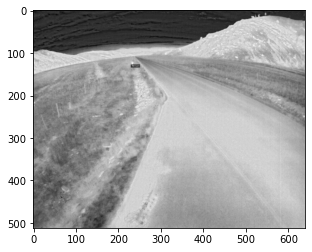

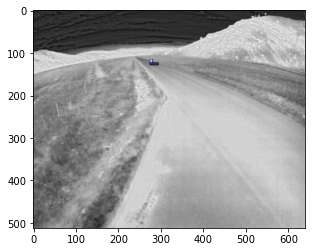

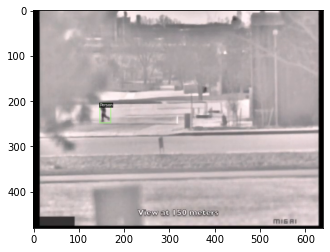

In [5]:
dataset_dicts = get_thing_dicts(data_folder+"train/"+'train.json')
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(
        img[:, :, ::-1], 
        metadata=thing_metadata, 
        scale=1
    )
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

## Train!

Train with RetinaNet

In [6]:
# zooed_model = \
#     'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'
zooed_model = \
    'COCO-Detection/retinanet_R_50_FPN_1x.yaml'

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(zooed_model))
# cfg.INPUT.MIN_SIZE_TRAIN = (400,)
cfg.DATASETS.TRAIN = ("thing_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(zooed_model)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
cfg.MODEL.RETINANET.NUM_CLASSES = len(thing_classes)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrectly use num_classes+1 here.

Loading config c:\users\admin\desktop\canadian application\jobs\detectron2\detectron2\detectron2\model_zoo\configs\COCO-Detection\../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [7]:
cfg.OUTPUT_DIR

'./output'

In [ ]:
from detectron2.engine import DefaultTrainer

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/11 02:28:48 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

[04/11 02:28:48 d2.data.build]: Removed 0 images with no usable annotations. 184 images left.
[04/11 02:28:48 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   Person   | 251          |
|            |              |
[04/11 02:28:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/11 02:28:48 d2.data.build]: Using training sampler TrainingSampler
[04/11 02:28:48 d2.data.common]: Serializing 184 elements to byte tensors and concatenating them all ...
[04/11 02:28:48 d2.data.common]: Serialized dataset takes 0.03 MiB


Skip loading parameter 'head.cls_score.weight' to the model due to incompatible shapes: (720, 256, 3, 3) in the checkpoint but (9, 256, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'head.cls_score.bias' to the model due to incompatible shapes: (720,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
head.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


[04/11 02:28:50 d2.engine.train_loop]: Starting training from iteration 0


C:\Anaconda3\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/11 02:29:07 d2.utils.events]:  eta: 1:55:34  iter: 19  total_loss: 1.358  loss_cls: 1.064  loss_box_reg: 0.2657  time: 0.6953  data_time: 0.0755  lr: 4.9953e-06  max_mem: 1647M
[04/11 02:29:17 d2.utils.events]:  eta: 1:45:54  iter: 39  total_loss: 1.25  loss_cls: 0.9918  loss_box_reg: 0.2915  time: 0.5913  data_time: 0.0010  lr: 9.9902e-06  max_mem: 1647M


In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output